In [5]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
from pyne.material import Material

/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [6]:
import analysis as an

In [7]:
# metrics to get
# does it transition?
# pu inventory
# raffinate
# lwr unf reprocessed
# reprocessing throughput
# unreprocessed lwr amount

In [8]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [9]:
def metric_solver(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')
    
    # pu generated
    storage_id = an.get_agent_ids(cur, 'storage')
    rep_id = an.get_agent_ids(cur, 'separations')
    lwr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['uox_waste'], False, True)
    sfr_fuel_out = an.facility_commodity_flux(cur, storage_id, ['sfr_used'], False, True)
    blanket = an.facility_commodity_flux(cur, storage_id, ['blanket_used'], False, True)
    legacy = an.facility_commodity_flux(cur, rep_id, ['pre_2013_unf'], False, True)
    if len(legacy['pre_2013_unf']) == 0:
        print('This one does not have legacy pu')
    pu_generated = ((lwr_pu * np.array(lwr_fuel_out['uox_waste'])) +
                    (np.array(sfr_fuel_out['sfr_used']) * sfr_used_pu) +
                    (np.array(blanket['blanket_used']) * blanket_used_pu))
    try:
        pu_generate += np.array(legacy['pre_2013_unf']) * legacy_pu
    except:
        print('I TOLD YOU NO LEGACY')

    # pu used
    mixer_id = an.get_agent_ids(cur, 'mixer')
    sfr_fuel_in = an.facility_commodity_flux(cur, mixer_id, ['sfr_fuel_new', 'sfr_fuel_legacy'], True, True)
    total_sfr_fuel_in = np.array(sfr_fuel_in['sfr_fuel_new']) + np.array(sfr_fuel_in['sfr_fuel_legacy'])
    pu_used = (total_sfr_fuel_in * sfr_pu)
    
    # lwr reprocessed
    legacy_sfr = np.array(sfr_fuel_in['sfr_fuel_legacy'])
    legacy_pu = legacy_sfr * sfr_pu
    legacy_lwr_reprocessed = legacy_pu / lwr_pu
    print('LEGACY LWR REPROCESSED: %f' %legacy_lwr_reprocessed[-1])
    output_dict['lwr UNF reprocessed'] = legacy_lwr_reprocessed[-1]
    
    # unreprocessed lwr amount
    lwr_amount = lwr_fuel_out['uox_waste'][-1]
    try:
        lwr_amount += legacy['pre_2013_unf'][-1]
    except:
        print('NO LEGACY')
    unreprocessed_lwr = lwr_amount - legacy_lwr_reprocessed[-1]
    print('UNREPROCESSED LWR: %f' %unreprocessed_lwr)
    output_dict['unreprocessed lwr'] = unreprocessed_lwr
    
    # sfr reprocessing throughput
    new_sfr = np.array(sfr_fuel_in['sfr_fuel_new'])
    new_sfr_reprocesed = new_sfr * sfr_pu / sfr_used_pu
    reprocessing_throughput = new_sfr_reprocesed + legacy_lwr_reprocessed
    print('SFR UNF REPROCESSED: %f' %new_sfr_reprocesed[-1])
    output_dict['sfr UNF reprocessed'] = new_sfr_reprocesed[-1]

    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux(cur, sink_id, ['reprocess_waste'], False, True)
    output_dict['raffinate'] = raffinate['reprocess_waste'][-1]
    print('RAFFINATE: %f' %raffinate['reprocess_waste'][-1])

    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)

    output_dict['decay heat'] = np.nansum(list(dict(z.decay_heat()).values()))
    output_dict['activity'] = np.nansum(list(dict(z.activity()).values()))
    print('decay heat: %f' %output_dict['decay heat'])
    print('activity: %f' %output_dict['activity'])

    # get them metrics
    pu_inventory = pu_generated - pu_used
    output_dict['pu inventory'] = pu_inventory[-1]
    print('PU INVENTORY: %f' %pu_inventory[-1])
    return output_dict

In [18]:
def metric_solver2(cur):
    output_dict = OrderedDict({})
    #lwr_pu = get_element_content(cur, 'uox_waste', 94)
    lwr_pu = 0.01260317036747676
    #sfr_pu = get_element_content(cur, 'sfr_fuel_legacy', 94)
    sfr_pu = 0.14983784204641132
    #sfr_used_pu = get_element_content(cur, 'sfr_used', 94)
    sfr_used_pu = 0.14624442551485697
    #blanket_used_pu = get_element_content(cur, 'blanket_used', 94)
    blanket_used_pu = 0.053485218171692765
    try:
        legacy_pu = get_element_content(cur, 'pre_2013_unf', 94)
        legacy_pu = 0.011819328439342202
    except:
        print('This one does not have legacy pu')

    # natural uranium usage
    output_dict['natural uranium'] = an.nat_u_timeseries(cur, True)[-1]
    
    # average reprocessing
    mixer_id = an.get_agent_ids(cur, 'mixer')
    sfr_fuel_in = an.facility_commodity_flux(cur, mixer_id, ['sfr_fuel_new', 'sfr_fuel_legacy'], True, True)
    legacy_sfr = np.array(sfr_fuel_in['sfr_fuel_legacy'])
    legacy_pu = legacy_sfr * sfr_pu
    legacy_lwr_reprocessed = legacy_pu / lwr_pu
    # average from 2030 - 2120 (90 years)
    avg_lwr_reprocessed = legacy_lwr_reprocessed[-1] / 90
    
    new_sfr = np.array(sfr_fuel_in['sfr_fuel_new'])
    new_sfr_reprocessed = new_sfr * sfr_pu / sfr_used_pu
    avg_sfr_reprocessed = new_sfr_reprocessed[-1] / 90
    output_dict['lwr annual reprocessing'] = avg_lwr_reprocessed
    output_dict['sfr annual reprocessing'] = avg_sfr_reprocessed
    output_dict['total annual reprocessing'] = avg_lwr_reprocessed + avg_sfr_reprocessed  
    
    # raffinate
    sink_id = an.get_agent_ids(cur, 'sink')
    raffinate = an.facility_commodity_flux(cur, sink_id, ['reprocess_waste'], False, True)
    output_dict['raffinate'] = raffinate['reprocess_waste'][-1]
    print('RAFFINATE: %f' %raffinate['reprocess_waste'][-1])

    raffinate = an.facility_commodity_flux_isotopics(cur, sink_id, ['reprocess_waste'], False, True)
    comp_dict = {}
    for key, value in raffinate.items():
        comp_dict[key] = value[-1]
    z = Material(comp_dict)
    
    return output_dict

In [19]:
# get all output files
file_list = []
for root, dirs, files in os.walk('./output/sweep'):
    for file in files:
        if file.endswith('.sqlite'):
            file_list.append(os.path.join(root, file))
print(file_list)

['./output/sweep/2030_005_growth_no.sqlite', './output/sweep/2030_005_growth_precise.sqlite', './output/sweep/2030_005_growth_recipe.sqlite', './output/sweep/2030_015_growth_no.sqlite', './output/sweep/2030_015_growth_precise.sqlite', './output/sweep/2030_015_growth_recipe.sqlite', './output/sweep/2030_01_growth_no.sqlite', './output/sweep/2030_01_growth_precise.sqlite', './output/sweep/2030_01_growth_recipe.sqlite', './output/sweep/2030_0_growth_no.sqlite', './output/sweep/2030_0_growth_precise.sqlite', './output/sweep/2030_0_growth_recipe.sqlite', './output/sweep/2035_005_growth_no.sqlite', './output/sweep/2035_005_growth_precise.sqlite', './output/sweep/2035_005_growth_recipe.sqlite', './output/sweep/2035_015_growth_no.sqlite', './output/sweep/2035_015_growth_precise.sqlite', './output/sweep/2035_015_growth_recipe.sqlite', './output/sweep/2035_01_growth_no.sqlite', './output/sweep/2035_01_growth_precise.sqlite', './output/sweep/2035_01_growth_recipe.sqlite', './output/sweep/2035_0_g

In [20]:
# do work
f = open('./output/metrics2', 'w')
for file in file_list:
    if 'precise' not in file:
        continue
    if file != file_list[0]:
        f = open('./output/metrics2', 'a+')
    outputname = '%s' %(file.replace('./output/sweep/', '').replace('.sqlite', ''))
    print('DOING %s' %outputname)
    cur = an.get_cursor(file)
    out_dict = metric_solver2(cur)
    f.write('%s\n======================' %outputname)
    for key, val in out_dict.items():
        write_string = '%s:\t%s\ttons' %(key, str(val))
        f.write(write_string)
    f.write('\n')
    f.close()


DOING 2030_005_growth_precise
RAFFINATE: 9702.281119
H3
0.001178909591617909
He3
0.0019304837162278778
C14
0.00797457406773935
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
6.752500340897
Kr85
1.970701266173781
Rb85
14.187113499458098
Sr90
82.92843204642807
Y90
0.021035246890775183
Zr90
18.79229524995574
Zr93
152.71907957820306
Nb93
0.000668346077974193
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
105.16616621238005
Tc99
236.0510886887364
Ru99
0.005870942517131641
Ru101
162.05484167027194
Ru106
5.473246866993748
Rh103
164.93229145997773
Rh106
5.094323472361354e-06
Pd105
124.89539822235766
Pd106
126.35450883047545
Pd107
97.64113129270395
Pd108
65.17805337625606
Ag107
6.652232902639274e-05
Ag108M
1.870788284041769e-05
Ag109
39.845448511833915
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
10.91812734625571
Sb125
0.022554549430512685
Sb126
1.4983920688613448e-06
Te12

RAFFINATE: 16780.588680
H3
0.001209843974597861
He3
0.0019365166115106194
C14
0.007974575181729185
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
13.389710329020724
Kr85
2.3111347901481163
Rb85
5.135583926225354
Sr90
326.2756180292363
Y90
0.08276158140603426
Zr90
38.17714085723896
Zr93
243.07812564149458
Nb93
0.0007864287126814067
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
209.34440612557376
Tc99
587.6939511548746
Ru99
0.009580928557078481
Ru101
302.30757294472244
Ru106
10.949667064822691
Rh103
306.0377810399261
Rh106
1.0225267258290513e-05
Pd105
231.73428249209306
Pd106
245.61663085383006
Pd107
166.10588680167427
Pd108
122.00861063334972
Ag107
9.045219562446424e-05
Ag108M
1.870788284041769e-05
Ag109
79.29885826012706
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
19.9446467850616
Sb125
0.022554549430512685
Sb126
2.8760439831421957e-06
Te124
6.571248608213023e-05

RAFFINATE: 13010.721599
H3
0.001193640250181878
He3
0.0019333565235057845
C14
0.007974575691889935
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
9.882294266386694
Kr85
2.132812468089264
Rb85
19.19722949170866
Sr90
105.77819665722187
Y90
0.026831213703641638
Zr90
20.525616961970446
Zr93
194.92571172108958
Nb93
0.0007238252200980612
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
153.85682272385924
Tc99
304.3628258822604
Ru99
0.006558615793758964
Ru101
232.45734553194413
Ru106
8.010420497586782
Rh103
236.23418266369583
Rh106
7.4709083160960925e-06
Pd105
178.88847631326513
Pd106
182.23571152572126
Pd107
131.88045629762289
Pd108
93.61851697160701
Ag107
7.777631045605981e-05
Ag108M
1.870788284041769e-05
Ag109
58.32185131671219
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
15.174606462999135
Sb125
0.022554549430512685
Sb126
2.1654928750286013e-06
Te124
6.571248608213023e-

RAFFINATE: 7462.301626
H3
0.0011641789330603433
He3
0.0019276109089512343
C14
0.007974573547877424
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
4.704709437047508
Kr85
1.80859006432899
Rb85
10.05993060234497
Sr90
72.89908228868525
Y90
0.018491247889444274
Zr90
18.00582668374175
Zr93
125.10779518684262
Nb93
0.0006320481008681697
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
73.31278152857048
Tc99
195.1822857458183
Ru99
0.005447748886124348
Ru101
107.41551004746434
Ru106
3.8136583507086432
Rh103
108.65027065881654
Rh106
3.540733367805939e-06
Pd105
82.26056429227587
Pd106
89.7956410067776
Pd107
71.00510220274886
Pd108
43.020663635749955
Ag107
5.915850577690067e-05
Ag108M
1.870788284041769e-05
Ag109
27.75782753938398
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
8.13315829551257
Sb125
0.022554549430512685
Sb126
8.572998122262899e-07
Te124
6.571248608213023e-05
Te125
0

RAFFINATE: 8794.362651
H3
0.0012039233829812988
He3
0.0019353619639697857
C14
0.00797457466186726
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
5.45995371137714
Kr85
2.2459785570546456
Rb85
12.664626561563239
Sr90
77.62866748617402
Y90
0.019690932845074758
Zr90
18.38552933233349
Zr93
135.30106373032905
Nb93
0.0006454363886399911
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
85.07138010057679
Tc99
218.1629380688618
Ru99
0.005688681482561652
Ru101
133.00662815667803
Ru106
4.4268510855512195
Rh103
135.5155573625732
Rh106
4.115746605899637e-06
Pd105
102.619568486329
Pd106
103.28774014400408
Pd107
83.51229100121063
Pd108
53.44171122927616
Ag107
6.187356839155294e-05
Ag108M
1.870788284041769e-05
Ag109
32.21902468907461
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
9.16028070620652
Sb125
0.022554549430512685
Sb126
1.156459763554563e-06
Te124
6.571248608213023e-05
Te125
0

RAFFINATE: 16223.064858
H3
0.001245877431693869
He3
0.001943543940081399
C14
0.007974576954411748
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
12.337300552388871
Kr85
2.7076837301447494
Rb85
23.059806388493374
Sr90
134.20463642639155
Y90
0.03404173443838149
Zr90
22.613306048755668
Zr93
228.28431373222492
Nb93
0.0007674682999153336
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
192.3217895621294
Tc99
376.4753155346255
Ru99
0.007258420665781064
Ru101
280.6434389103711
Ru106
10.028885267050443
Rh103
283.94232455922173
Rh106
9.360611135437837e-06
Pd105
214.989035214391
Pd106
226.29231867894026
Pd107
155.39264411325496
Pd108
113.06631507918941
Ag107
8.662247377651949e-05
Ag108M
1.870788284041769e-05
Ag109
72.89477506690497
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
18.513383148178885
Sb125
0.022554549430512685
Sb126
2.6664964276118874e-06
Te124
6.571248608213023e-05

RAFFINATE: 11900.090968
H3
0.0012241497103218594
He3
0.0019393065493484277
C14
0.007974576360283836
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
8.302446549636437
Kr85
2.468569707428152
Rb85
3.714917066147206
Sr90
234.6322839967625
Y90
0.05951575232551338
Zr90
30.953216567013165
Zr93
173.63789776821227
Nb93
0.0006958267104012952
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
129.29740358209895
Tc99
426.11619228840294
Ru99
0.007904958311972849
Ru101
186.59217643318615
Ru106
6.73163871308141
Rh103
188.9519019296271
Rh106
6.2778086939972665e-06
Pd105
143.07993067948146
Pd106
154.04336509256012
Pd107
109.94319887716404
Pd108
75.3849608010154
Ag107
7.209568988257314e-05
Ag108M
1.870788284041769e-05
Ag109
49.00083328375937
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
13.026034073227473
Sb125
0.022554549430512685
Sb126
1.8275666259334882e-06
Te124
6.571248608213023e-05


RAFFINATE: 6653.645292
H3
0.0011864448900416947
He3
0.0019319532676440037
C14
0.007974574142005338
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
3.5536555103519447
Kr85
2.0536273810497456
Rb85
8.600693632618734
Sr90
68.83663111401648
Y90
0.017460785099637242
Zr90
17.685176274822318
Zr93
109.59739761911078
Nb93
0.0006116481675949212
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
55.41870740597163
Tc99
179.87220226860478
Ru99
0.005288603168675342
Ru101
81.54850122437024
Ru106
2.881910798423701
Rh103
82.45499334082766
Rh106
2.673054650074194e-06
Pd105
62.42417441860625
Pd106
69.25474797571556
Pd107
58.423457242652546
Pd108
32.569494155949045
Ag107
5.501854660617045e-05
Ag108M
1.870788284041769e-05
Ag109
20.96654052043161
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
6.567739894855841
Sb125
0.022554549430512685
Sb126
5.217155652133012e-07
Te124
6.571248608213023e-05
Te

RAFFINATE: 7114.138091
H3
0.0012500416755746797
He3
0.0019443560606037683
C14
0.007974576211751856
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
3.06690828207836
Kr85
2.753511320110231
Rb85
9.935211046312931
Sr90
67.30685223317639
Y90
0.017072748383487272
Zr90
17.600486750637373
Zr93
103.09383155513771
Nb93
0.0006030482594157637
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
47.911615977691376
Tc99
184.60753159478048
Ru99
0.005349340829011858
Ru101
79.28743364139508
Ru106
2.4941230557845073
Rh103
81.11003305320322
Rh106
2.2831814166328818e-06
Pd105
61.42055615289683
Pd106
60.6177102370247
Pd107
57.37824385715739
Pd108
31.731726296752765
Ag107
5.327323295161424e-05
Ag108M
1.870788284041769e-05
Ag109
18.11229616524309
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
5.905769981946968
Sb125
0.022554549430512685
Sb126
4.682809385523447e-07
Te124
6.571248608213023e-05
Te12

RAFFINATE: 14377.741710
H3
0.0013035819538180229
He3
0.0019547976101332667
C14
0.007974579707322467
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
9.620579005547505
Kr85
3.342723188623381
Rb85
20.021543821025716
Sr90
123.3189526810719
Y90
0.03128052167326498
Zr90
21.78489009337062
Zr93
191.5125679388285
Nb93
0.0007192424861502895
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
149.91085195941812
Tc99
340.1376940692975
Ru99
0.006890518075969194
Ru101
219.34595718527524
Ru106
7.811325852765914
Rh103
221.8863162438279
Rh106
7.279760068633395e-06
Pd105
167.99875107102702
Pd106
177.66602600552213
Pd107
125.59949998579317
Pd108
88.32345052660256
Ag107
7.684345173338686e-05
Ag108M
1.870788284041769e-05
Ag109
56.8137918485267
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
14.818677105087565
Sb125
0.022554549430512685
Sb126
2.0529535113733095e-06
Te124
6.571248608213023e-05
Te

RAFFINATE: 10031.881030
H3
0.0012753954052179928
He3
0.00194930060389928
C14
0.007974577931188479
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
5.642137126110786
Kr85
3.0325296387864187
Rb85
14.32618416801922
Sr90
87.76737803898723
Y90
0.02226267180564189
Zr90
19.155598383801266
Zr93
137.83376686419166
Nb93
0.000648706799733752
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
87.98763381926388
Tc99
245.18918243067793
Ru99
0.00595996842694418
Ru101
137.23656043139914
Ru106
4.583070300008548
Rh103
139.79979245674565
Rh106
4.254658026438838e-06
Pd105
105.86302830705284
Pd106
106.60789955814526
Pd107
85.55947660125534
Pd108
55.13972981098162
Ag107
6.253519938372208e-05
Ag108M
1.870788284041769e-05
Ag109
33.318652872954345
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
9.408047785666687
Sb125
0.022554549430512685
Sb126
1.1650265606722116e-06
Te124
6.571248608213023e-05
Te1

RAFFINATE: 5126.442158
H3
0.001228653892469949
He3
0.00194018496542194
C14
0.007974575543357955
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
1.3742363186265885
Kr85
2.518138325049784
Rb85
5.931625687813749
Sr90
59.844650864251506
Y90
0.015179920504429687
Zr90
16.96456107892951
Zr93
80.26506468646447
Nb93
0.0005730046265608899
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
21.575934754284408
Tc99
149.42136356767253
Ru99
0.0049686193432936804
Ru101
32.624456545615274
Ru106
1.1216910274475973
Rh103
32.905909841101455
Rh106
8.008391412779582e-07
Pd105
24.90274250397956
Pd106
30.3936528319159
Pd107
34.62225035751674
Pd108
12.797445618876369
Ag107
4.7181005772610066e-05
Ag108M
1.870788284041769e-05
Ag109
8.119041720757714
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
3.6037580810189485
Sb125
0.022554549430512685
Sb126
2.689026026316808e-07
Te124
6.571248608213023e-05
Te

RAFFINATE: 6185.203958
H3
0.0012754803897933786
He3
0.0019493171777887335
C14
0.007974576211751856
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
1.745076670399853
Kr85
3.0334648957946895
Rb85
8.210011935251911
Sr90
63.541992496026865
Y90
0.016117771277013786
Zr90
17.316821711978758
Zr93
85.29963889189507
Nb93
0.0005796317199005339
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
27.381494684888242
Tc99
168.07491167845478
Ru99
0.005181777548322556
Ru101
49.60877008051139
Ru106
1.4260948754809362
Rh103
51.05267043642339
Rh106
1.1765347686215672e-06
Pd105
38.65942280206934
Pd106
37.044706346097136
Pd107
42.94030549163971
Pd108
19.738025465768356
Ag107
4.852274077304087e-05
Ag108M
1.870788284041769e-05
Ag109
10.31895163706367
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
4.108096146254886
Sb125
0.022554549430512685
Sb126
3.341705030148515e-07
Te124
6.571248608213023e-05


RAFFINATE: 13055.134402
H3
0.0013398137082605837
He3
0.0019618636111135594
C14
0.00797462678282105
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
7.738325316087458
Kr85
3.741454395016943
Rb85
3.3384108268284467
Sr90
265.28526454802386
Y90
0.06729104721439924
Zr90
33.383523125975614
Zr93
166.17484059996013
Nb93
0.0006858987428926373
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
120.67729324887041
Tc99
475.00848340905225
Ru99
0.008416434715161484
Ru101
174.18036446287746
Ru106
6.290564626513027
Rh103
176.37327838963182
Rh106
5.83564460626177e-06
Pd105
133.55338776173886
Pd106
144.09933940853145
Pd107
103.88491766545367
Pd108
70.34812221451757
Ag107
7.007882844080663e-05
Ag108M
1.870788284041769e-05
Ag109
45.716507538089544
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
12.258836517389309
Sb125
0.022554549430512685
Sb126
1.6759528063371441e-06
Te124
6.571248608213023e-

RAFFINATE: 8928.842291
H3
0.0013056215834733563
He3
0.0019551953834502267
C14
0.007974583325069609
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
4.07215382434233
Kr85
3.36516935513054
Rb85
2.645938382687041
Sr90
181.2605515884318
Y90
0.045977722719827856
Zr90
26.74828110311224
Zr93
116.70047304987901
Nb93
0.0006208951202088673
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
63.60490443598747
Tc99
330.58058252480663
Ru99
0.006914667443495523
Ru101
91.62546539683491
Ru106
3.3147018923856706
Rh103
92.77225915798626
Rh106
3.027068179029716e-06
Pd105
70.24717094667312
Pd106
78.61075560390495
Pd107
63.74293149869493
Pd108
37.00574168386497
Ag107
5.6893479923522525e-05
Ag108M
1.870788284041769e-05
Ag109
24.062702924790333
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
7.272890872238987
Sb125
0.022554549430512685
Sb126
8.626001327430419e-07
Te124
6.571248608213023e-05
Te125


RAFFINATE: 4362.879804
H3
0.0012492768144647473
He3
0.001944206895612012
C14
0.007974575543357955
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
0.29192503392296987
Kr85
2.74509400778894
Rb85
3.0821345257344
Sr90
67.93760813165522
Y90
0.01723274304062597
Zr90
17.543670025543307
Zr93
65.69617618490282
Nb93
0.0005538162711044931
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
4.766952618997258
Tc99
147.05440991334768
Ru99
0.004924910867479819
Ru101
8.325071531440607
Ru106
0.24729846029961544
Rh103
8.296354505449706
Rh106
8.696102945366749e-08
Pd105
6.266987130003442
Pd106
11.092987778838285
Pd107
22.801073904612498
Pd108
2.9774774706278384
Ag107
4.328933526016141e-05
Ag108M
1.870788284041769e-05
Ag109
1.7381752357823412
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
2.131828781253304
Sb125
0.022554549430512685
Sb126
2.560832227639431e-07
Te124
6.571248608213023e-05
Te12

RAFFINATE: 5946.737728
H3
0.0012820808579608101
He3
0.0019506044164350309
C14
0.007974576211751856
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
1.404754352427721
Kr85
3.1061031843803457
Rb85
7.693656824045227
Sr90
63.52958352232045
Y90
0.016114623673482244
Zr90
17.32477596358014
Zr93
80.71768659998801
Nb93
0.0005736049665060722
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
22.095093531295266
Tc99
164.9273425371316
Ru99
0.0051518942728240435
Ru101
41.966704160549206
Ru106
1.1510486988150976
Rh103
43.31316424072223
Rh106
9.178304216723134e-07
Pd105
32.79863761129913
Pd106
30.97499456496302
Pd107
39.22271007823151
Pd108
16.64981175498731
Ag107
4.730088281054807e-05
Ag108M
1.870788284041769e-05
Ag109
8.31226173160043
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
3.6452622108917203
Sb125
0.022554549430512685
Sb126
3.225837558270708e-07
Te124
6.571248608213023e-05
Te12

RAFFINATE: 12410.361221
H3
0.0013575754831127618
He3
0.0019653275537364913
C14
0.007974738033272737
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
6.819393405132804
Kr85
3.93692309432399
Rb85
16.44790605063955
Sr90
114.20222930868074
Y90
0.02896801530794766
Zr90
21.077344869613
Zr93
153.80298550366857
Nb93
0.0006696121082699034
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
106.40331846003974
Tc99
303.8926658598884
Ru99
0.006517585407627181
Ru101
156.45082964216792
Ru106
5.54791779948128
Rh103
158.18872720792515
Rh106
5.143818753589649e-06
Pd105
119.76334423233757
Pd106
127.71023649223581
Pd107
95.00265923290793
Pd108
62.90645324120837
Ag107
6.677487922206041e-05
Ag108M
1.870788284041769e-05
Ag109
40.298159533562796
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
11.009101045404323
Sb125
0.022554549430512685
Sb126
1.501227124013005e-06
Te124
6.571248608213023e-05
Te12

RAFFINATE: 8527.811592
H3
0.0013166695773981663
He3
0.001957349988909005
C14
0.007974619789670259
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
3.500634279569666
Kr85
3.486752756587367
Rb85
11.588275576055434
Sr90
81.6198911684315
Y90
0.02070332839483744
Zr90
18.70135503580661
Zr93
109.00542943610377
Nb93
0.0006107699319080149
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
54.726817771099
Tc99
218.53510678788314
Ru99
0.005692758129686404
Ru101
89.15420095226705
Ru106
2.8527641160163055
Rh103
91.1038936641198
Rh106
2.590899852844808e-06
Pd105
68.98774138281176
Pd106
68.41728590570227
Pd107
62.168583034364765
Pd108
35.708741088830244
Ag107
5.483923187750828e-05
Ag108M
1.870788284041769e-05
Ag109
20.69266067041572
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
6.4956317091600795
Sb125
0.022554549430512685
Sb126
7.461163445244013e-07
Te124
6.571248608213023e-05
Te125
0.

RAFFINATE: 4291.574320
H3
0.0012525628844511035
He3
0.0019448477526199622
C14
0.007974575543357955
N14
2.0545966668548973e-05
Se79
0.3600666948214478
Br79
1.5781999636195042e-05
Kr83
0.1707776869831837
Kr85
2.7812572758976164
Rb85
2.894829952676691
Sr90
71.13696540311324
Y90
0.018044277377356633
Zr90
17.877249676762847
Zr93
64.06304142985972
Nb93
0.0005517059591245204
Nb94
0.0001251415696340899
Mo94
8.54253867583852e-08
Mo95
2.8828833057760925
Tc99
150.27230975687266
Ru99
0.004984143623413715
Ru101
5.601573173956308
Ru106
0.14915645157934443
Rh103
5.538373564748646
Rh106
7.747672358408449e-08
Pd105
4.178511271579626
Pd106
8.930474546436159
Pd107
21.4764617890977
Pd108
1.8771867712683137
Ag107
4.285962558047233e-05
Ag108M
1.870788284041769e-05
Ag109
1.0231824373800675
Ag110M
2.378589767742291e-06
Cd110
2.095821850646528e-07
Cd113
1.4909069036578496e-08
In115
5.872639290803586e-09
Sn126
1.9670699617992753
Sb125
0.022554549430512685
Sb126
2.56144854397923e-07
Te124
6.571248608213023e-05
T

In [21]:
with open('./output/prettier_metric', 'w') as w:
    with open('./output/metrics2', 'r') as f:
        lines = f.readlines()
        for line in lines:
            if '======================' in line:
                line = line.replace('======================', '======================\n')
            if 'tons' in line:
                line = line.replace('tons', 'tons\n')
            w.write(line)


In [22]:
!cat ./output/prettier_metric

2030_005_growth_precise
natural uranium:	950722.2434656046	tons
lwr annual reprocessing:	1490.441214513737	tons
sfr annual reprocessing:	782.3625581960855	tons
total annual reprocessing:	2272.8037727098226	tons
raffinate:	9702.281118651397	tons

2030_015_growth_precise
natural uranium:	1182878.338438126	tons
lwr annual reprocessing:	2424.6081589431487	tons
sfr annual reprocessing:	1560.9432187874277	tons
total annual reprocessing:	3985.5513777305764	tons
raffinate:	16780.588679909364	tons

2030_01_growth_precise
natural uranium:	1061272.764881091	tons
lwr annual reprocessing:	2242.5695373231497	tons
sfr annual reprocessing:	1145.3897106810387	tons
total annual reprocessing:	3387.9592480041883	tons
raffinate:	13010.72159912563	tons

2030_0_growth_precise
natural uranium:	840171.7220501177	tons
lwr annual reprocessing:	914.6628063986974	tons
sfr annual reprocessing:	544.8383780759509	tons
total annual reprocessing:	1459.5011844746482	tons
raffinate:	7462.301626440995	tons

2035_005_growt

In [23]:
metric_dict = {}
with open('./output/prettier_metric', 'r') as f:
    lines = f.readlines()
    for indx,line in enumerate(lines):
        if 'growth' in line:
            z = line.split('_')
            key = str(z[0]) + '_' + str(z[1]) + '_' + str(z[-1]).replace('\n', '')
            metric_dict[key] = {'Natural uranium': lines[indx + 2],
                                'LWR annual reprocessing': lines[indx + 3],
                                'SFR annual reprocessing': lines[indx + 4],
                                'Total annual reprocessing': lines[indx + 5],
                                'Raffinate': lines[indx + 6]}
            for metric, val in metric_dict[key].items():
                metric_dict[key][metric] = float(val.split()[-2])
                if 'Activity' in metric:
                    # mega curies
                    metric_dict[key][metric] = metric_dict[key][metric] * 2.7e-11 * 1e-6 * 1e-6
                if 'Heat' in metric:
                    # MW
                    metric_dict[key][metric] = metric_dict[key][metric] * 1e-6
                metric_dict[key][metric] = round(metric_dict[key][metric],3)


In [25]:
print(list(metric_dict.keys()))
print(list(metric_dict['2030_005_precise'].keys()))
print(metric_dict['2050_005_precise'])

['2030_005_precise', '2030_015_precise', '2030_01_precise', '2030_0_precise', '2035_005_precise', '2035_015_precise', '2035_01_precise', '2035_0_precise', '2040_005_precise', '2040_015_precise', '2040_01_precise', '2040_0_precise', '2045_005_precise', '2045_015_precise', '2045_01_precise', '2045_0_precise', '2050_005_precise', '2050_015_precise', '2050_01_precise', '2050_0_precise']
['Natural uranium', 'LWR annual reprocessing', 'SFR annual reprocessing', 'Total annual reprocessing', 'Raffinate']
{'Natural uranium': 1790697.62, 'LWR annual reprocessing': 938.637, 'SFR annual reprocessing': 162.832, 'Total annual reprocessing': 1101.468, 'Raffinate': 5946.738}


In [30]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
def get_3d_metric(metric_dict, metric, no=False):
    year_list = []
    rate_list = []
    metric_list = []
    for indx, year in enumerate(['2030', '2035', '2040', '2045', '2050']):
        for key, val in metric_dict.items():
            skip = False
            for failures in ['2030_01', '2030_015', '2035_015']:
                if failures in key:
                    skip = True
            if not skip:
                if year in key and 'precise' in key:
                    year_list.append(year)
                    metric_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_list.append(rate)
    
    #!!!!!
    dm_dy_list = []
    dm_dr_list = []
    
    dm_dr_abs = []
    dm_dy_abs = []
    year_list = [int(year) for year in year_list]
    plt.scatter(rate_list, year_list, c=metric_list, cmap='viridis', s=4500, marker='s')
    comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
    cbar = plt.colorbar(format=comma_fmt)
    cbar.set_label('Mass [t]')
    cbar.outline.set_visible(False) 
    for indx,year in enumerate(year_list):
        r = rate_list[indx]
        mi = metric_list[indx]
        # find index for next year
        try:
            y1 = [i for i, x in enumerate(year_list) if x == year + 5]
            y2 = [i for i, x in enumerate(rate_list) if x == r]
            yi = np.intersect1d(y1, y2)[0]
            # increase ratio
            dm_dy = (metric_list[yi] - mi) / mi
            dm_dy_list.append((metric_list[yi] - mi) / mi)
            dm_dy_abs.append(metric_list[yi] - mi)
        except:
            dm_dy = 0
            dm_dy_list.append(0)
            dm_dy_abs.append(0)
            print('%i_%f Does not have next year' %(int(year), r))
        try:
            r1 = [i for i, x in enumerate(rate_list) if x == r + 0.5]
            r2 = [i for i, x in enumerate(year_list) if x == year]
            ri = np.intersect1d(r1, r2)[0]
            # increase ratio
            dm_dr = (metric_list[ri] - mi) / mi
            dm_dr_list.append((metric_list[ri] - mi) / mi)
            dm_dr_abs.append(metric_list[ri] - mi)
        except:
            dm_dr = 0
            dm_dr_list.append(0)
            dm_dr_abs.append(0)
            print("%i_%f Doesn't have a next rate" %(int(year), r))
        year = float(year)
        if dm_dy < 0:
            plt.scatter(r, year+1.3, s=dm_dy * -1000, marker=r'$\downarrow$', color='white')
        else:
            plt.scatter(r, year+1.3, s=dm_dy * 1000, marker=r'$\uparrow$', color='white')
        if dm_dr < 0:
            plt.scatter(r+0.25, year, s=dm_dr * -1000, marker=r'$\leftarrow$', color='white')
        else:
            plt.scatter(r+0.25, year, s=dm_dr * 1000, marker=r'$\rightarrow$', color='white')
    print('THE AVERAGE dm/dy: %f(%f percent) per 5 years'
          %(sum(dm_dy_abs)/len(dm_dy_abs), sum(dm_dy_list)/len(dm_dy_list) * 100))
    print('THE AVERAGE dm/dr: %f(%f percent) per 5 percent'
          %(sum(dm_dr_abs)/len(dm_dr_abs), sum(dm_dr_list)/len(dm_dr_list) * 100))
    
     
    plt.xlabel('Annual Power Demand Growth Rate [%]')
    plt.ylabel('SFR Available Year')
    plt.title(metric + ' for different US transition scenarios')
    # create legend for arrow size
    q = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=1000)
    w = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=500)
    e = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=250)
    r = plt.scatter([], [], marker=r'$\uparrow$', color='blue', s=125)
    labels = ['100%', '50%', '25%', '12.5%']
    lgd = plt.legend([q,w,e,r], labels, ncol=4, fontsize=10,
                     bbox_to_anchor=(1.1, -0.2), borderaxespad=0.)
    path = './output/sweep_images/scat_both_' + str(metric) + '.png'
    path = path.replace(' ', '_')
    plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()

In [31]:
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
def get_size_dots(metric_dict, metric, no=False):
    year_list = []
    rate_list = []
    metric_list = []
    for indx, year in enumerate(['2030', '2035', '2040', '2045', '2050']):
        for key, val in metric_dict.items():
            skip = False
            for failures in ['2030_01', '2030_015', '2035_015']:
                if failures in key:
                    skip = True
            if not skip:
                if year in key and 'precise' in key:
                    year_list.append(year)
                    metric_list.append(val[metric])
                    rate = float(key.split('_')[1])
                    if rate == 15:
                        rate = 1.5
                    if rate == 5:
                        rate = 0.5
                    rate_list.append(rate)
    year_list = [int(year) for year in year_list]
    norm_metric_list = [x * 2000 / max(metric_list) for x in metric_list]
    plt.scatter(rate_list, year_list, s=norm_metric_list, cmap='viridis')
    q = plt.scatter([], [], color='blue', s=2000)
    w = plt.scatter([], [], color='blue', s=1000)
    e = plt.scatter([], [], color='blue', s=500)
    r = plt.scatter([], [], color='blue', s=250)
    labels = [max(metric_list), max(metric_list) / 2, max(metric_list) /4, max(metric_list) / 2]
    labels = ["{:,}".format(int(x)) for x in labels]
    lgd = plt.legend([q,w,e,r], labels, loc=(1.0, 0), fontsize=30)
       
    plt.xlabel('Annual Power Demand Growth Rate [%]')
    plt.ylabel('SFR Available Year')
    plt.title(metric + ' for different US transition scenarios')
    path = './output/sweep_images/scat_size' + str(metric) + '.png'
    path = path.replace(' ', '_')
    plt.tight_layout()
    plt.savefig(path, bbox_extra_artists=(lgd, ), bbox_inches='tight',)
    plt.show()
    plt.close()

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: 162574.296235(12.526181 percent) per 5 years
THE AVERAGE dm/dr: 147875.125824(9.623281 percent) per 5 percent


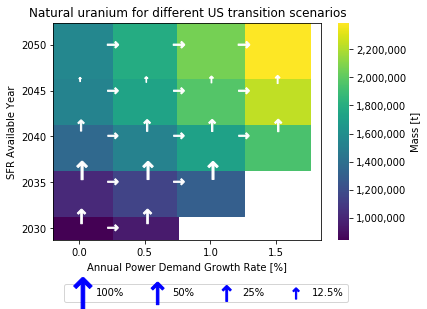

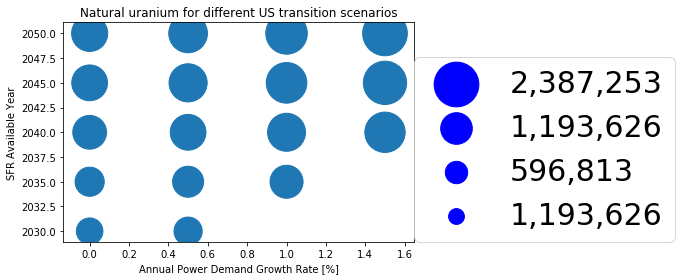

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -108.420059(-8.226746 percent) per 5 years
THE AVERAGE dm/dr: 619.782176(58.415314 percent) per 5 percent


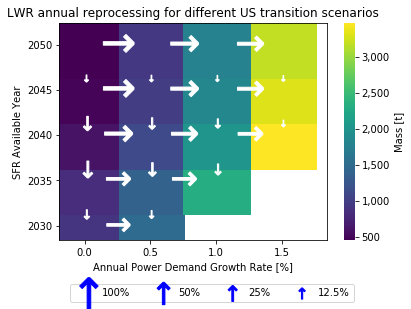

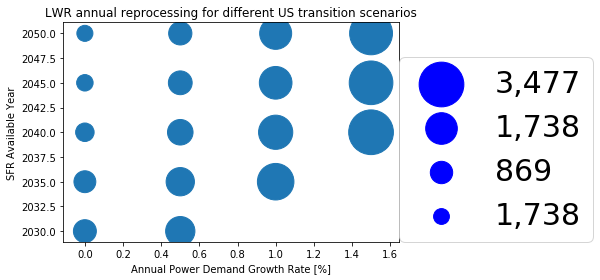

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -119.152412(-25.703646 percent) per 5 years
THE AVERAGE dm/dr: 198.745353(124.381493 percent) per 5 percent


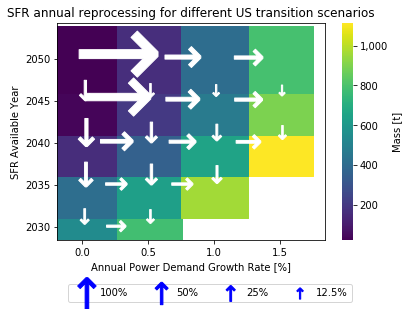

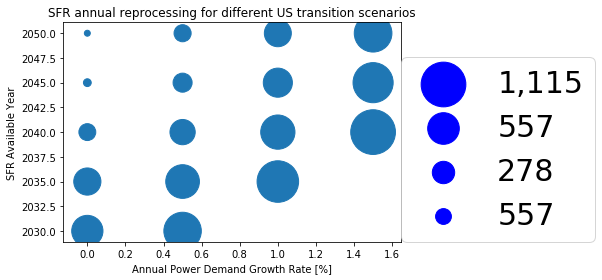

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -227.572529(-12.401297 percent) per 5 years
THE AVERAGE dm/dr: 818.527588(62.247389 percent) per 5 percent


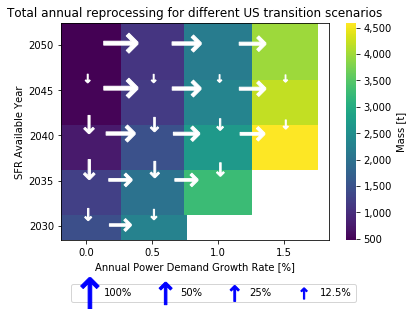

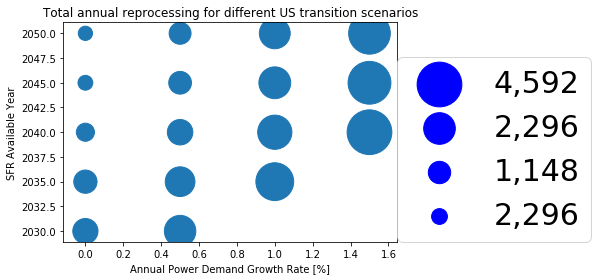

2030_0.500000 Doesn't have a next rate
2035_1.000000 Doesn't have a next rate
2040_1.500000 Doesn't have a next rate
2045_1.500000 Doesn't have a next rate
2050_0.500000 Does not have next year
2050_1.500000 Does not have next year
2050_1.500000 Doesn't have a next rate
2050_1.000000 Does not have next year
2050_0.000000 Does not have next year
THE AVERAGE dm/dy: -721.525353(-8.295211 percent) per 5 years
THE AVERAGE dm/dr: 1973.456824(28.261887 percent) per 5 percent


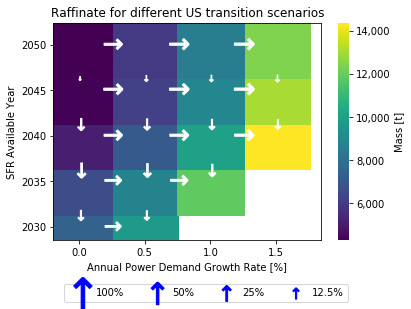

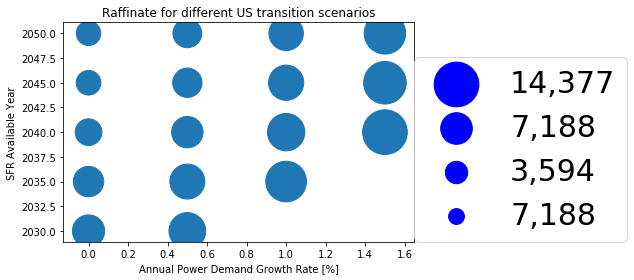

In [33]:
for key in metric_dict['2030_005_precise'].keys():
    get_3d_metric(metric_dict, key)
    get_size_dots(metric_dict, key)

In [47]:
cur = an.get_cursor('./output/sweep/2030_0_growth_no.sqlite')
z = cur.execute('SELECT distinct(commodity) FROM transactions').fetchall()
for row in z:
    print(row['commodity'])

natl_u
uox
tailings
uox_waste
cooled_uox
lwr_u
lwr_pu
reprocess_waste
blanket
sfr_fuel_legacy
sfr_used
blanket_used
cooled_blanket
sfr_pu
sfr_u
cooled_sfr
sfr_fuel_new
